## [1. Import Needed Modules](#import) ##
## [2. Read in images and create a dataframe of image paths and class labels](#makedf) ## 
## [3. Trim the train_df dataframe](#trim) ##
## [4. Create train, test and validation generators](#generators) ## 
## [5. Create a function to show Training Image Samples](#show) ## 
## [6. Create the Model](#model) ## 
## [7. Create a custom Keras callback to continue or halt training](#callback) ## 
## [8. Instantiate custom callback and create callbacks to control learning rate and early stopping](#callbacks) ##
## [9. Train the model](#train) ##
## [10. Define a function to plot the training data](#plot) ##
## [11. Make predictions on test set, create Confusion Matrix and Classification Report](#result) ##
## [12. Save the model](#save) ##

<a id="import"></a>
# <center>Import Need Modules</center>

In [1]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
# pprevent annoying tensorflow warning
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings
pd.set_option('max_columns', None)
pd.set_option('max_rows', 90)
warnings.simplefilter("ignore")

<a id="makedf"></a>
# <center>Read in images and create a dataframe of image paths and class labels</center>


In [2]:
sdir=r'../input/pistachio-image-dataset/Pistachio_Image_Dataset/Pistachio_Image_Dataset'
ht=0
wt=0
samples=0
sample_count=10
filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir, klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)    
        for i, f in enumerate(flist):
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
            #  get image shape to use for averaging of image shapes
            if i < sample_count:
                img=plt.imread(fpath)               
                ht += img.shape[0]
                wt += img.shape[1]
                samples +=1        
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
class_count= len(df['labels'].unique())
print('The dataframe has ', class_count, ' classes')
# split df into train_df, test_df and valid_df
train_df, dummy_df=train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels']) 
valid_df, test_df = train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])    
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
classes=list(train_df['labels'].unique())
class_count = len(classes)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
for label in train_df['labels'].unique():
      group=groups.get_group(label)      
      print('{0:^30s} {1:^13s}'.format(label, str(len(group))))
wave=wt/samples
have=ht/samples
aspect_ratio= have/wave
print ('Average Image Height: ' ,have, '  Average Image Width: ', wave, '  Aspect ratio: ', aspect_ratio)

The dataframe has  2  classes
train_df lenght:  1718   test_df length:  215   valid_df length:  215
            CLASS               IMAGE COUNT 
       Siirt_Pistachio              733     
      Kirmizi_Pistachio             985     
Average Image Height:  600.0   Average Image Width:  600.0   Aspect ratio:  1.0


### The dataset is well balanced but has more images per class than is necessary. Limit the number of images in each class
### to 500 using the trim function defined below

<a id="trim"></a>
# <center>Trim the df dataframe to max and min samples</center>

In [3]:
def trim (df, max_size, min_size, column):
    df=df.copy()
    original_class_count= len(list(df[column].unique()))    
    sample_list=[] 
    groups=df.groupby(column)
    for label in df[column].unique():        
        group=groups.get_group(label)
        sample_count=len(group)         
        if sample_count> max_size :
            strat=group[column]
            samples,_=train_test_split(group, train_size=max_size, shuffle=True, random_state=123, stratify=strat)            
            sample_list.append(samples)
        elif sample_count>= min_size:
            sample_list.append(group)
    df=pd.concat(sample_list, axis=0).reset_index(drop=True)
    final_class_count= len(list(df[column].unique())) 
    if final_class_count != original_class_count:
        print ('*** WARNING***  dataframe has a reduced number of classes from ', original_class_count,' to ', final_class_count )
    groups=df.groupby('labels')
    print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
    for label in train_df['labels'].unique():
          group=groups.get_group(label)      
          print('{0:^30s} {1:^13s}'.format(label, str(len(group))))
    return df

In [4]:
max_samples=500
min_samples=0
column='labels'
train_df=trim(train_df, max_samples, min_samples, column)

            CLASS               IMAGE COUNT 
       Siirt_Pistachio              500     
      Kirmizi_Pistachio             500     


In [5]:
# override with our df
our_df = pd.read_csv("../input/train-val-test-pistachios/pistachios.csv", index_col=0)
df = pd.DataFrame()
df["labels"] = our_df["pistachio_type"].map({0: "Kirmizi_Pistachio", 1: "Siirt_Pistachio"})
df["filepaths"] = our_df["filename"]
base = "../input/pistachio-image-dataset/Pistachio_Image_Dataset/Pistachio_Image_Dataset"
df.loc[df.filepaths.str.contains("kirmizi"), "filepaths"] = "{}/Kirmizi_Pistachio/".format(base) + df.loc[df.filepaths.str.contains("kirmizi"), "filepaths"]
df.loc[df.filepaths.str.contains("siirt"), "filepaths"] = "{}/Siirt_Pistachio/".format(base) + df.loc[df.filepaths.str.contains("siirt"), "filepaths"]
print(sum(df.filepaths.str.contains("\(")))
df.head()

115


,labels,filepaths
0,Kirmizi_Pistachio,../input/pistachio-image-dataset/Pistachio_Ima...
1,Kirmizi_Pistachio,../input/pistachio-image-dataset/Pistachio_Ima...
2,Kirmizi_Pistachio,../input/pistachio-image-dataset/Pistachio_Ima...
3,Kirmizi_Pistachio,../input/pistachio-image-dataset/Pistachio_Ima...
4,Kirmizi_Pistachio,../input/pistachio-image-dataset/Pistachio_Ima...


In [6]:
# override with our train, val, and test dfs
train_labels = pd.read_csv("../input/train-val-test-pistachios/pistachios_with_cnn_train_labels.csv", index_col=0)
train_df = df.loc[train_labels.index]
val_labels = pd.read_csv("../input/train-val-test-pistachios/pistachios_with_cnn_val_labels.csv", index_col=0)
valid_df = df.loc[val_labels.index]
test_labels = pd.read_csv("../input/train-val-test-pistachios/pistachios_with_cnn_test_labels.csv", index_col=0)
test_df = df.loc[test_labels.index]
train_df.labels.value_counts(), valid_df.labels.value_counts(), test_df.labels.value_counts()

(Kirmizi_Pistachio    872
 Siirt_Pistachio      674
 Name: labels, dtype: int64,
 Kirmizi_Pistachio    238
 Siirt_Pistachio      149
 Name: labels, dtype: int64,
 Kirmizi_Pistachio    122
 Siirt_Pistachio       93
 Name: labels, dtype: int64)

<a id="generators"></a>
# <center>Create the train_gen, test_gen and valid_gen</center>

In [7]:
working_dir=r'./'
img_size=(300,300)
batch_size=25 # We will use and EfficientetB3 model, with image size of (200, 250) this size should not cause resource error
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2 )
t_and_v_gen=ImageDataGenerator()
# train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
#                                    class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
# valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
#                                    class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='sparse', color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='sparse', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
# test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
#                                    class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='sparse', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
print ('{0:^25s}{1:^12s}'.format('class name', 'class index'))
for klass, index in zip(classes, class_indices):
    print(f'{klass:^25s}{str(index):^12s}')

Found 1546 validated image filenames belonging to 2 classes.
Found 387 validated image filenames belonging to 2 classes.
Found 215 validated image filenames belonging to 2 classes.
test batch size:  43   test steps:  5  number of classes :  2
       class name        class index 
    Kirmizi_Pistachio         0      
     Siirt_Pistachio          1      


<a id="show"></a>
# <center>Create a function to show example training images</center>

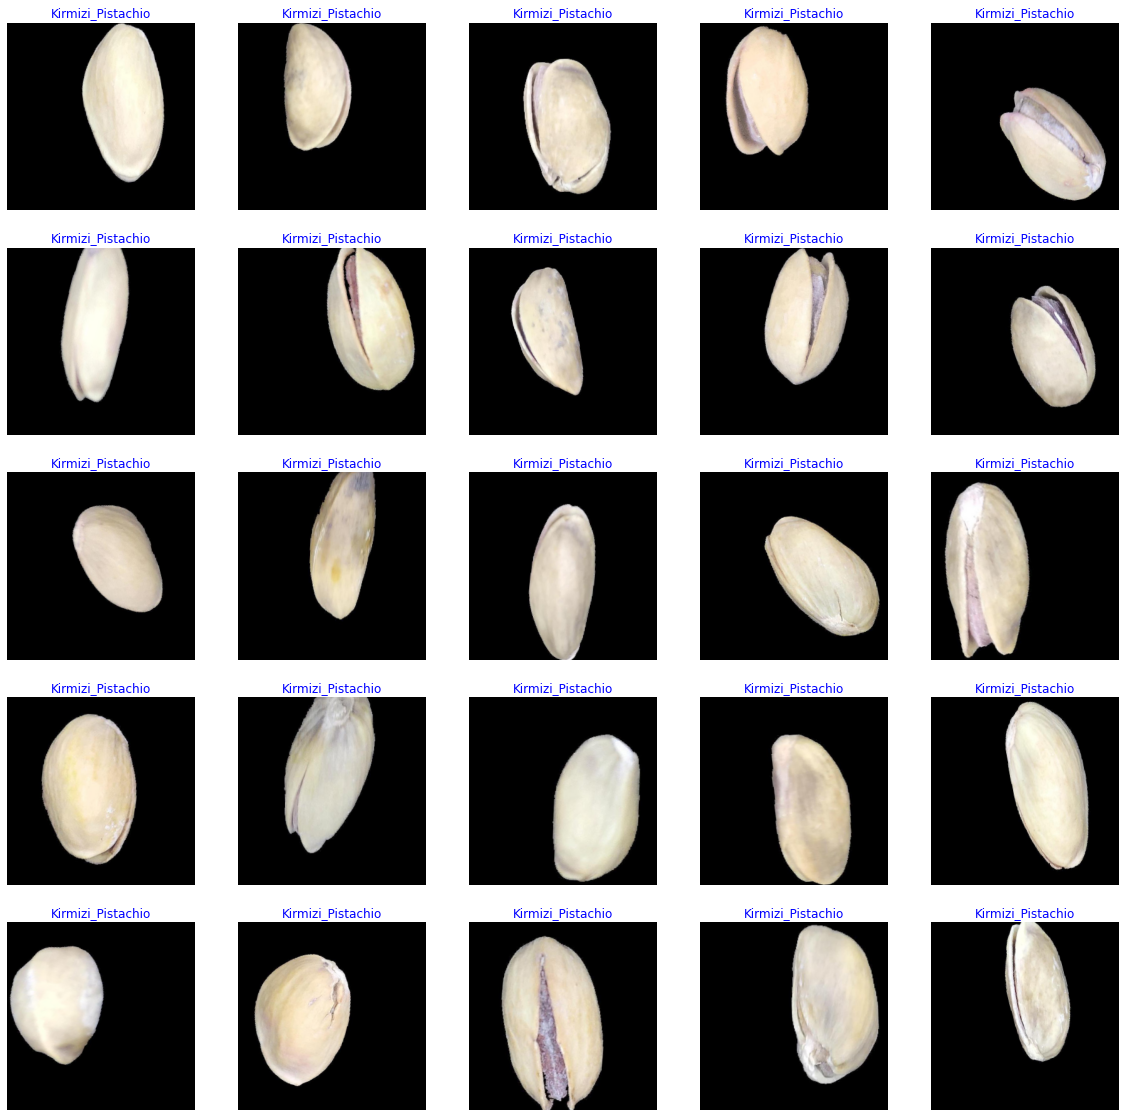

In [8]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

<a id="model"></a>
# <center>Create a model using transfer learning with EfficientNetB3</center>
### NOTE experts advise you make the base model initially not trainable. Then train for some number of epochs
### then fine tune model by making base model trainable and run more epochs
### I have found this to be WRONG!!!!
### Making the base model trainable from the outset leads to faster convegence and a lower validation loss
### for the same number of total epochs!

In [9]:
img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(128, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)
x = Dense(8, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
# model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 
model.compile(Adamax(learning_rate=lr), loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

2022-07-29 23:45:04.410241: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 23:45:04.531021: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 23:45:04.531880: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 23:45:04.533998: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

43950080/43941136 [==============================] - 0s 0us/step


<a id="callback"></a>
# <center>Create a custom Keras callback to continue or halt training</center>

In [10]:
class ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training     
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)

<a id="callbacks"></a>
# <center>Instantiate custom callback and create 2 callbacks to control learning rate and early stop

In [11]:
epochs=40
ask_epoch=40
ask=ASK(model, epochs,  ask_epoch)
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, verbose=1,restore_best_weights=True)
callbacks=[rlronp, estop, ask]

<a id="train"></a>
# <center>Train the model
### Note unlike how you are told it is BETTER to make the base model trainable from the outset
### It will converge faster and have a lower validation losss

In [12]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

ask_epoch >= epochs, will train for  40  epochs
Training will proceed until epoch 40  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/40


2022-07-29 23:45:11.646965: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-29 23:45:27.693424: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


62/62 [==============================] - 92s 1s/step - loss: 4.7482 - sparse_categorical_accuracy: 0.7710 - val_loss: 5.4680 - val_sparse_categorical_accuracy: 0.8062
Epoch 2/40
62/62 [==============================] - 56s 894ms/step - loss: 4.0648 - sparse_categorical_accuracy: 0.8952 - val_loss: 4.2060 - val_sparse_categorical_accuracy: 0.7984
Epoch 3/40
62/62 [==============================] - 55s 882ms/step - loss: 3.5240 - sparse_categorical_accuracy: 0.9166 - val_loss: 3.3456 - val_sparse_categorical_accuracy: 0.9199
Epoch 4/40
62/62 [==============================] - 56s 891ms/step - loss: 3.1151 - sparse_categorical_accuracy: 0.9366 - val_loss: 2.8775 - val_sparse_categorical_accuracy: 0.9432
Epoch 5/40
62/62 [==============================] - 57s 911ms/step - loss: 2.7830 - sparse_categorical_accuracy: 0.9502 - val_loss: 2.6779 - val_sparse_categorical_accuracy: 0.8915
Epoch 6/40
62/62 [==============================] - 55s 888ms/step - loss: 2.4748 - sparse_categorical_accura

<a id="plot"></a>
# <center>Define a function to plot the training data

In [ ]:
# def tr_plot(tr_data, start_epoch):
#     #Plot the training and validation data
#     tacc=tr_data.history['accuracy']
#     tloss=tr_data.history['loss']
#     vacc=tr_data.history['val_accuracy']
#     vloss=tr_data.history['val_loss']
#     Epoch_count=len(tacc)+ start_epoch
#     Epochs=[]
#     for i in range (start_epoch ,Epoch_count):
#         Epochs.append(i+1)   
#     index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
#     val_lowest=vloss[index_loss]
#     index_acc=np.argmax(vacc)
#     acc_highest=vacc[index_acc]
#     plt.style.use('fivethirtyeight')
#     sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
#     vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
#     fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
#     axes[0].plot(Epochs,tloss, 'r', label='Training loss')
#     axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
#     axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
#     axes[0].set_title('Training and Validation Loss')
#     axes[0].set_xlabel('Epochs')
#     axes[0].set_ylabel('Loss')
#     axes[0].legend()
#     axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
#     axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
#     axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
#     axes[1].set_title('Training and Validation Accuracy')
#     axes[1].set_xlabel('Epochs')
#     axes[1].set_ylabel('Accuracy')
#     axes[1].legend()
#     plt.tight_layout    
#     plt.show()
    
# tr_plot(history,0)
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['sparse_categorical_accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_sparse_categorical_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
tr_plot(history,0)

<a id="result"></a>
# <center>Make predictions on test set, create Confusion Matrix and Classification Results

In [ ]:
y_pred= []
y_true=test_gen.labels
errors=0
preds=model.predict(test_gen, steps=test_steps, verbose=1) # predict on the test set
tests=len(preds)
for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
        y_pred.append(pred_index)
acc=( 1-errors/tests) * 100
print(f'there were {errors} in {tests} tests for an accuracy of {acc:6.2f}')
ypred=np.array(y_pred)
ytrue=np.array(y_true)
cm = confusion_matrix(ytrue, ypred )
# plot the confusion matrix
plt.figure(figsize=(16, 10))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
print("Classification Report:\n----------------------\n", clr)

<a id="save"></a>
# <center>Save the model

In [ ]:
subject='pistachios' 
acc=str(( 1-errors/tests) * 100)
index=acc.rfind('.')
acc=acc[:index + 3]
save_id= subject + '_' + str(acc) + '.h5' 
model_save_loc=os.path.join(working_dir, save_id)
model.save(model_save_loc)
print ('model was saved as ' , model_save_loc ) 
   

# Save second to last layer outputs

In [ ]:
len(df), batch_size, int(np.ceil(len(df)/batch_size))

In [ ]:
from keras import backend as K

# with a Sequential model
get_layer_output = K.function([model.layers[0].input],
                                  [model.layers[-2].output])

In [ ]:
gen=t_and_v_gen.flow_from_dataframe(df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='sparse', color_mode='rgb', shuffle=False, batch_size=batch_size)

In [ ]:
steps = int(np.ceil(len(df)/batch_size))
gen.reset()
labels = np.array([])
outputs = None
for i in range(steps):
    current, current_labels = gen.next()
    labels = np.concatenate([labels, current_labels])
    print(i, current.mean())
    current_output = get_layer_output(current)
    if outputs is None:
        outputs = current_output[0]
    else:
        outputs = np.concatenate([outputs, current_output[0]])

In [ ]:
outputs.shape

In [ ]:
out_df = pd.DataFrame(outputs)
out_df.to_csv("second_last_layer.csv")